<a href="https://colab.research.google.com/github/linguist89/Bookflix/blob/master/whisperx_alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ebooklib
!pip install -U lingtrain-aligner==0.4.3
!pip install razdel dateparser sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import os
from tqdm import tqdm
import ebooklib
import numpy as np
import matplotlib.pyplot as plt
from ebooklib import epub
from bs4 import BeautifulSoup as bs
from lingtrain_aligner import preprocessor, splitter, aligner, resolver, reader, helper, vis_helper

In [ ]:
# Epub books
def extract_contents(book_filename):
    # Load epub book into paragraphs
    book = epub.read_epub(book_filename)
    all_paragraphs = []
    for token in book.get_items_of_type(ebooklib.ITEM_DOCUMENT):
        soup = bs(token.get_content())
        input_soup = [soup.text.strip()]
        all_paragraphs.append(input_soup)
    text = ' '.join([' '.join(text) for text in all_paragraphs])
    return text

In [ ]:
text1 = extract_contents("Den_lille_prins.epub")
text1 = text1.split("\n")
text2 = extract_contents("The Little Prince - Antoine de Saint-Exupéry - EPUB.epub")
text2 = text2.split("\n")

In [ ]:
df = pd.read_csv("den_lille_prins.csv")
df.drop('Unnamed: 0', inplace=True, axis=1)

In [ ]:
# Creating the dictionary for the dictionary approach
import string

def create_words_dictionary():
    words = {}
    total_length = 0
    last_time_stamp = 0
    last_full_time_stamp = 0
    for i, row in df.transpose().sort_index().iterrows():
        start_range = eval(row[1])['word_segments'][0]['start'] + last_full_time_stamp
        end_range = eval(row[1])['word_segments'][-1]['end'] + last_full_time_stamp
        for j, segment in enumerate(eval(row[1])['word_segments']):
            text = segment['text'].strip()
            for p in string.punctuation:
                text = text.replace(p, "")
            start = segment['start'] + last_time_stamp
            end = segment['end'] + last_time_stamp
            if text.lower() in words.keys():
                words[text.lower()].append((start, end, start_range, end_range))
            else:
                words.update({text.lower(): [(start, end, start_range, end_range)]})
        last_time_stamp = end
        last_full_time_stamp = end_range
    return words, last_full_time_stamp
words, last_full_time_stamp = create_words_dictionary()

In [ ]:
whisper_text = []
for i, row in df.transpose().sort_index().iterrows():
    for s in eval(row[1])['segments']:
        start = s['start']
        end = s['end']
        text = s['text'].strip()
        whisper_text.append(text)
        #print(f"{start} -> {end} - {text}")

best fit line:
y = 0.48x + -0.00
-3.196873876731843e-10
0.4771004526389847


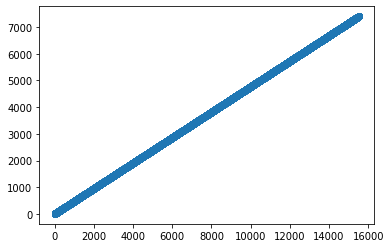

In [ ]:
# Calculate the line of best fit over the entire text and audio
total_words = [sentence.split() for sentence in whisper_text]
total_words = [i for j in total_words for i in j]
per_word_length = last_full_time_stamp/len(total_words)
current_time_stamp = 0
xy_line_best_fit = []
for i, word in enumerate(total_words):
    xy_line_best_fit.append((i, current_time_stamp))
    current_time_stamp += per_word_length 
x_line_best_fit = [xy[0] for xy in xy_line_best_fit]
y_line_best_fit = [xy[1] for xy in xy_line_best_fit]

# solve for a and b
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f}x + {:.2f}'.format(b, a))

    return a, b

c, m = best_fit(x_line_best_fit, y_line_best_fit)
plt.scatter(x_line_best_fit, y_line_best_fit)
yfit = [c + m * xi for xi in x_line_best_fit]
print(c)
print(m)
plt.plot(x_line_best_fit, yfit)

In [ ]:
# Align the texts
db_path = "full_cycle.db"

lang_from = "da"
lang_to = "en"

models = ["sentence_transformer_multilingual", "sentence_transformer_multilingual_labse"]
model_name = models[0]

text1_prepared = preprocessor.mark_paragraphs(text1)
text2_prepared = preprocessor.mark_paragraphs(text2)

splitted_from = splitter.split_by_sentences_wrapper(text1_prepared, lang_from, leave_marks=True)
splitted_to = splitter.split_by_sentences_wrapper(text2_prepared, lang_to, leave_marks=True)

if os.path.isfile(db_path):
    os.unlink(db_path)
    
aligner.fill_db(db_path, lang_from, lang_to, splitted_from, splitted_to)


aligner.align_db(db_path, \
                model_name, \
                batch_size=100, \
                window=40, \
                save_pic=False,
                embed_batch_size=10, \
                normalize_embeddings=True, \
                show_progress_bar=True
                )

batch: 0


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

batch: 1


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 2


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 3


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 4


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 5


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 6


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 7


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 8


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 9


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 10


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 11


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 12


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 13


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 14


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

batch: 15


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
conflicts_to_solve, rest = resolver.get_all_conflicts(db_path, min_chain_length=2, max_conflicts_len=6, batch_id=-1)

resolver.get_statistics(conflicts_to_solve)
resolver.get_statistics(rest)

conflicts to solve: 193
total conflicts: 218
('2:3', 64)
('3:3', 37)
('3:2', 18)
('2:1', 13)
('4:3', 10)
('4:5', 9)
('3:5', 9)
('3:4', 6)
('2:4', 6)
('4:4', 6)
('4:6', 4)
('4:2', 2)
('5:5', 2)
('6:6', 2)
('6:5', 1)
('2:5', 1)
('5:4', 1)
('5:2', 1)
('5:6', 1)
('5:7', 5)
('6:7', 2)
('6:8', 2)
('7:8', 2)
('4:7', 2)
('7:6', 2)
('6:9', 1)
('5:10', 1)
('5:8', 1)
('8:8', 1)
('10:13', 1)
('7:7', 1)
('9:7', 1)
('4:9', 1)
('5:11', 1)
('3:7', 1)


conflicts to solve: 193
total conflicts: 218


100%|██████████| 193/193 [01:50<00:00,  1.75it/s]


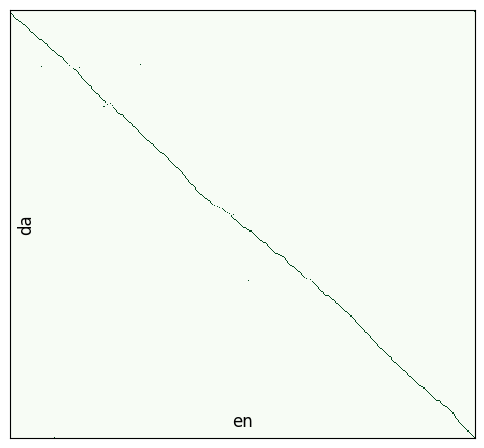

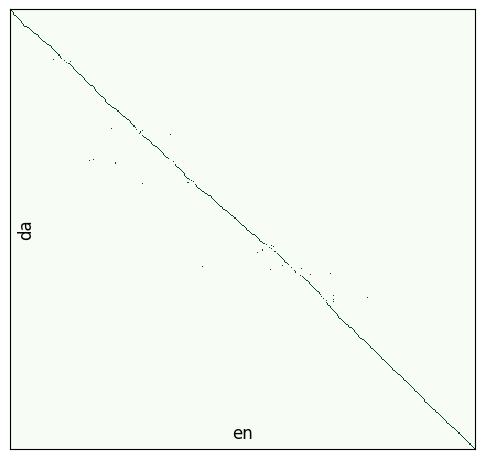

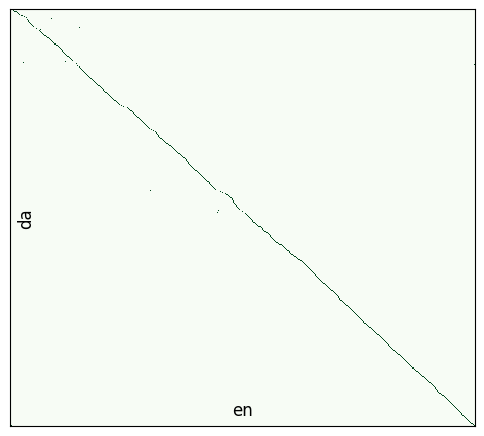

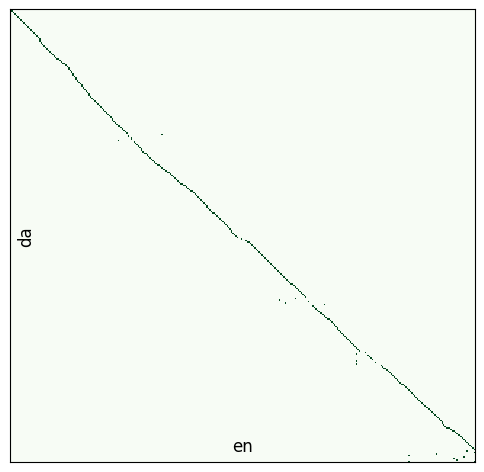

conflicts to solve: 22
total conflicts: 24


100%|██████████| 22/22 [01:17<00:00,  3.53s/it]


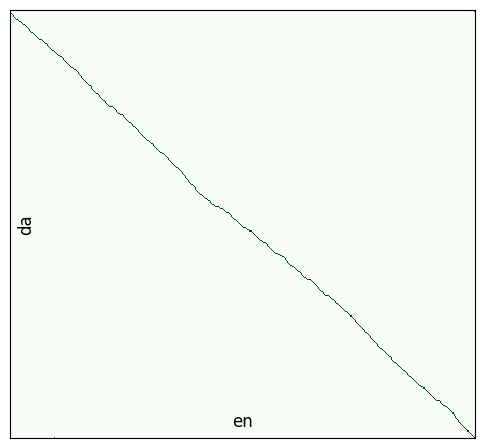

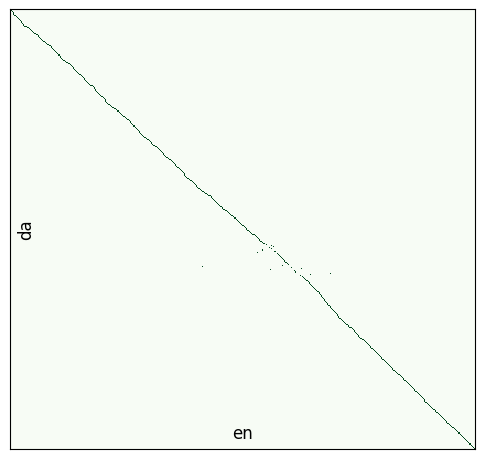

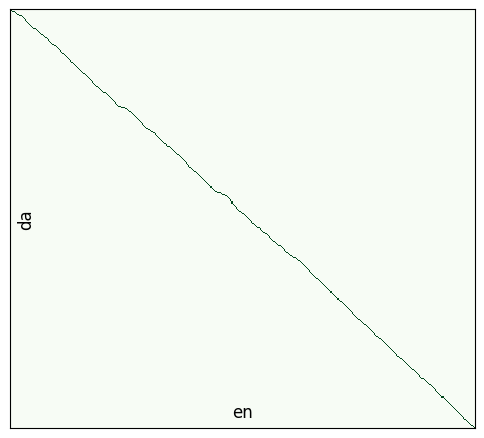

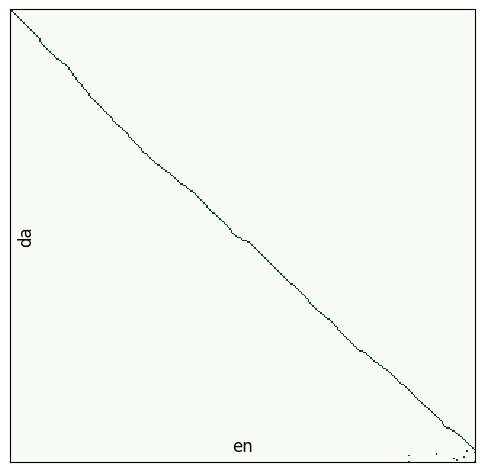

conflicts to solve: 2
total conflicts: 2


100%|██████████| 2/2 [00:11<00:00,  5.99s/it]


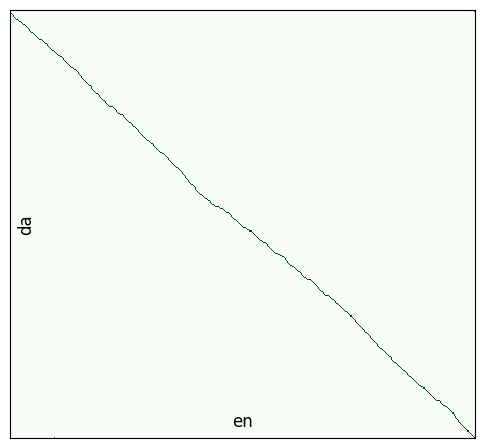

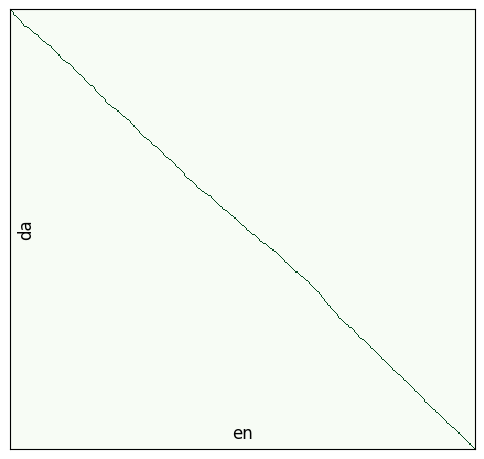

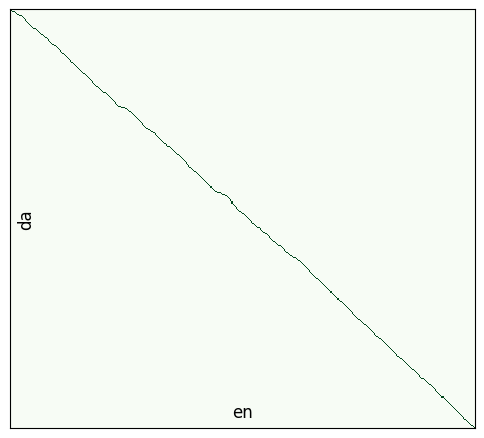

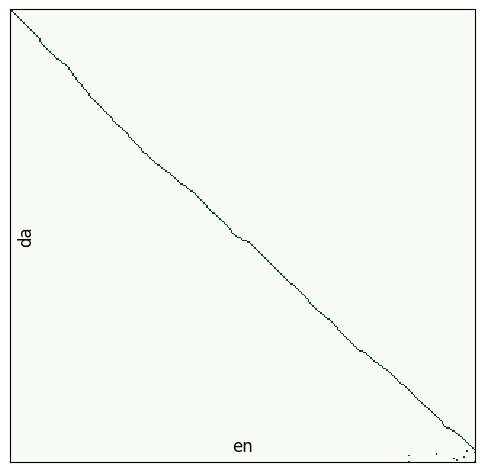

In [ ]:
steps = 3
batch_id = -1 #выровнять все доступные батчи

for i in range(steps):
    conflicts, rest = resolver.get_all_conflicts(db_path, min_chain_length=2+i, max_conflicts_len=6*(i+1), batch_id=batch_id)
    resolver.resolve_all_conflicts(db_path, conflicts, model_name, show_logs=False)
    vis_helper.visualize_alignment_by_db(db_path, output_path="img_test1.png", lang_name_from=lang_from, lang_name_to=lang_to, batch_size=400, size=(600,600), plt_show=True)

    if len(rest) == 0: break

In [ ]:
output_path = "result/the_little_prince.html"
paragraphs_from, paragraphs_to, meta = reader.get_paragraphs(db_path)

In [ ]:
reader.create_book(paragraphs_from, paragraphs_to, meta, output_path, template="simple")

In [ ]:
danish_text = paragraphs_from[2][0]
english_text = paragraphs_to[2][0]
print(danish_text)
print(english_text)

Til léon werth dengang han var en lille dreng 7 Da jeg var seks år, så jeg engang et pragtfuldt billede i en bog om urskoven, der hed »Sandfærdige Historier«.
To Leon Werth when he was a little boy. I When I was six years old, I once saw a magnificent picture in a book on the virgin forest called Stories of Life.


In [ ]:
# Trying a dictionary approach. This seems to work but need to make it better.
paragraphs_from_aligned = []
count = 0
window = 1
for i, paragraph in enumerate(tqdm(paragraphs_from)):
    temp_list = []
    for j, danish_text in enumerate(paragraph):
        danish_words = danish_text.split()
        for k, word in enumerate(danish_words):
            search_word = word.lower()
            for p in string.punctuation:
                search_word = search_word.replace(p, "")
            length = words.get(search_word, [(0, 0, 0, 0)])
            length = sorted(length, key=lambda x: x[0])
            if length[0][0] != 0:
                count += 1
            temp_list.append((word, length))            
    paragraphs_from_aligned.append(temp_list)
print(f"Total Count: {count}")

100%|██████████| 672/672 [00:00<00:00, 1383.48it/s]

Total Count: 14961


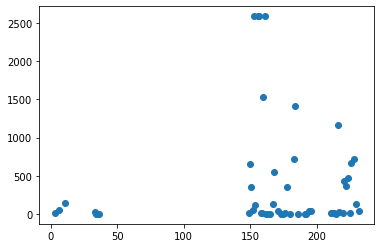

In [ ]:
def align_whisper_timing_plotting(paragraph):
    xy_information = []
    for i, (word, timings) in enumerate(paragraph):
        search_word = word.lower()
        for p in string.punctuation:
            search_word = search_word.replace(p, "")
        result = (i, words.get(search_word, [(0, 0, 0, 0, search_word)])[0][0])
        if result[1] != 0:
            xy_information.append(result)
    return xy_information     

position = 0
xy_information = align_whisper_timing_plotting(paragraphs_from_aligned[position])
x = [info[0] for info in xy_information]
y = [info[1] for info in xy_information]
plt.scatter(x, y)
plt.show()

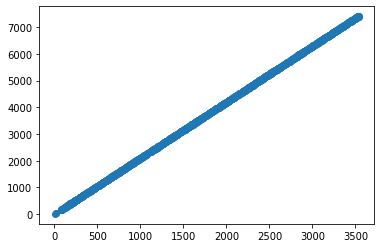

In [ ]:
# Straight-line function
def straight_line_formula_c(start_timings, 
                            y,
                            m=m,
                            optimal_c=c):
    result_timings = []
    for st in start_timings:
        x = st[0]
        inner_c = y-(m*x)
        result_timings.append((abs(inner_c-optimal_c), st))
    return sorted(result_timings, key=lambda x: x[0])[0]

word_count = 0
straight_line_xy_information = []
paragraphs_whisper_text_aligned = []
for paragraphs in paragraphs_from_aligned:
    temp_list = []
    for i, (word, timings) in enumerate(paragraphs):
        word_count += per_word_length
        long_result = straight_line_formula_c(start_timings=timings, y=word_count)
        result = straight_line_formula_c(start_timings=timings, y=word_count)[1][0]
        if long_result[0] < 10 and result != 0:
            straight_line_xy_information.append((word_count, result))
            temp_list.append((word, long_result[1]))
        else:
            temp_list.append((word, [0, 0, 0, 0]))
    paragraphs_whisper_text_aligned.append(temp_list)

x = [info[0] for info in straight_line_xy_information]
y = [info[1] for info in straight_line_xy_information]
plt.scatter(x, y)
plt.show()

In [ ]:
import copy
test_paragraphs = copy.deepcopy(paragraphs_whisper_text_aligned)
danish_english_text = []
for i, paragraph in enumerate(paragraphs_from):
    temp_list = []
    lengths = [len(p.split()) for p in paragraph]
    for l in lengths:
        t_list = []
        for n in range(0, l):
            t_list.append(test_paragraphs[i][0][1])
            test_paragraphs[i].pop(0)
        temp_list.append(t_list)
    #print(paragraphs_whisper_text_aligned[i][:162])
    danish_english_text.append(
        (temp_list, paragraph, paragraphs_to[i])
        )

In [ ]:
danish_english_text[100][0]

[[[0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  (3937.129474263867,
   3937.2300456924386,
   3873.4788514644442,
   4162.662646036672)]]

In [ ]:
first_n = 102
second_n = 0
print([e[0] for e in danish_english_text[first_n][0][second_n]])
print(danish_english_text[first_n][1][second_n])
print(danish_english_text[first_n][2][second_n])


[0, 3957.2630507087965, 3948.3582742638673, 0, 0, 0, 3934.93701712101]
– Men hvad nytter så tornene da?
"Then the thorns, what are they for?"
